In [1]:
import pandas as pd
import folium
from geopy import distance
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
import libpysal
from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from contextily import add_basemap
import networkx as nx
import numpy as np

In [16]:
df = pd.read_csv(r"C:\Users\marco\Downloads\Electric_Vehicle_Charging_Stations_in_New_York.csv")

In [17]:
df = df.drop(['Fuel Type Code', 'Intersection Directions','Station Phone','Status Code','Owner Type Code',
         'Federal Agency ID','Federal Agency Name','Cards Accepted',
         'EV Network Web','ZIP','Groups With Access Code','Expected Date','Access Days Time',
         'Geocode Status','Updated At','Plus4','Date Last Confirmed',"EV Other Info"], axis=1)

In [18]:
df.head()

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV Network,Latitude,Longitude,ID,Open Date,EV Connector Types
0,ShopRite Plaza,2333 Nott St E,Niskayuna,NY,NaN,2.0,NaN,Non-Networked,42.816614,-73.889657,50854,04/20/2021,J1772
1,GMC Copley Parking - Tesla,2000 Broadway,New York,NY,NaN,3.0,NaN,Tesla,40.775496,-73.981552,115044,09/01/2017,TESLA
2,WHITE PLAINS EVSE1,1 Maple Ave,White Plains,NY,NaN,2.0,NaN,ChargePoint Network,41.028410,-73.759380,197206,10/07/2021,J1772
3,3500 Dekalb Ave,3500 Dekalb Ave,Bronx,NY,NaN,2.0,NaN,FLO,40.882337,-73.880265,201636,11/25/2021,J1772
4,134 N 4th St,134 N 4th St,Brooklyn,NY,NaN,4.0,NaN,FLO,40.716441,-73.960043,202931,12/22/2021,J1772


Vengono eliminate le colonne che non presentano dati utili all'analisi o che presentano dei NaN in ogni osservazione.

In [19]:
df.index.names = ['Index']
# df["Weight"],
# df["Distance"] = ""
df = df.fillna(value=0)
df.shape

(3140, 13)

Il dataset presenta 3140 osservazioni, anche decidendo di dividere il grafo in più parti in modo da poterlo visualizzare meglio non risulta comunque possibile evidenziare forti relazioni. Quello che si può evincere è solo che il grid ricopre la quasi totalità dello Stato di New York, con una (ovvia) concentrazione maggiore nella città omonomia. 

In [20]:
# df["EV Level1 EVSE Num"],df["EV Level2 EVSE Num"] = df["EV Level1 EVSE Num"].astype('int'),df["EV Level2 EVSE Num"].astype('int')
# df["EV DC Fast Count"]=df["EV DC Fast Count"].astype('int')
# for i in range(0, (df.shape[0])):
#         df["Weight"][i] = df["EV Level1 EVSE Num"][i] +df["EV Level2 EVSE Num"][i]+df["EV DC Fast Count"][i]

In [21]:
lista = ['New York',"Bronx","Brooklyn","Queens","Staten Island",
         "Manhattan","Borough Park","Washington Heights","New York City",
        "Astoria","Jamaica","JAMAICA","Jackson Heights"]
NYC_df = df.query("City in @lista")

In [22]:
NYC_df["Next Latitude"],NYC_df["Next Longitude"] = "",""
for i in range(0, (NYC_df.shape[0]-1)):
    NYC_df["Next Latitude"][i] = NYC_df["Latitude"][i+1]
    NYC_df["Next Longitude"][i] = NYC_df["Longitude"][i+1]

C:\Users\marco\AppData\Local\Temp\ipykernel_12948\1936939642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NYC_df["Next Latitude"],NYC_df["Next Longitude"] = "",""
C:\Users\marco\AppData\Local\Temp\ipykernel_12948\1936939642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NYC_df["Next Latitude"],NYC_df["Next Longitude"] = "",""
C:\Users\marco\AppData\Local\Temp\ipykernel_12948\1936939642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

KeyError: 2

In [15]:
# for i in range(0, (df.shape[0]-1)):
#     df["Distance"][i]= (distance.distance((df['Latitude'][i],df['Longitude'][i]),(df['Latitude'][i+1],df['Longitude'][i+1])))

In [9]:
df.head()

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV Network,Latitude,Longitude,ID,Open Date,EV Connector Types,Weight,Distance
Index,,,,,,,,,,,,,,,
0,ShopRite Plaza,2333 Nott St E,Niskayuna,NY,0,2,0,Non-Networked,42.816614,-73.889657,50854,04/20/2021,J1772,2,226.83420600554723 km
1,GMC Copley Parking - Tesla,2000 Broadway,New York,NY,0,3,0,Tesla,40.775496,-73.981552,115044,09/01/2017,TESLA,3,33.75351466375259 km
2,WHITE PLAINS EVSE1,1 Maple Ave,White Plains,NY,0,2,0,ChargePoint Network,41.028410,-73.759380,197206,10/07/2021,J1772,2,19.150210449067778 km
3,3500 Dekalb Ave,3500 Dekalb Ave,Bronx,NY,0,2,0,FLO,40.882337,-73.880265,201636,11/25/2021,J1772,2,19.614374264231003 km
4,134 N 4th St,134 N 4th St,Brooklyn,NY,0,4,0,FLO,40.716441,-73.960043,202931,12/22/2021,J1772,4,172.00549655782325 km


In [14]:
networks = df['EV Network'].unique()
# connector_types = df['EV Connector Types'].unique()
print(networks)
# print(connector_types)
# network_list = []
# for network in networks:
#     network =df[df["EV Network"] == network]
#     network_list.append(network)
# print(network_list[1])

['Non-Networked' 'Tesla' 'ChargePoint Network' 'FLO' 'LIVINGSTON'
 'SemaCharge Network' 'AMPUP' 'EV Connect' 'SHELL_RECHARGE'
 'Blink Network' 'Volta' 'eVgo Network' 'OpConnect' 'Electrify America'
 'SWTCH' 'RIVIAN_WAYPOINTS' 'FLASH' 'EVGATEWAY' 'CHARGELAB']


In [ ]:
# tesla_df = df[df['EV Network'] =="Tesla"]
# nonet_df = df[df['EV Network'] =="Non-Networked"]
# flo_df = df[df['EV Network'] =="FLO"]
# cpn_df = df[df['EV Network'] =="ChargePoint Network"]
# evc_df = df[df['EV Network'] =="EV Connect"]
# ea_df = df[df['EV Network'] =="Electrify America"]
# l_df = df[df['EV Network'] =="LIVINGSTON"]
# bn_df = df[df['EV Network'] =="Blink Network"]
# sr_df = df[df['EV Network'] =="SHELL_RECHARGE"]
# v_df = df[df['EV Network'] =="Volta"]
# en_df = df[df['EV Network'] =="eVgo Network"]
# oc_df = df[df['EV Network'] =="OpConnect"]
# sw_df = df[df['EV Network'] =="SWTCH"]
# rw_df = df[df['EV Network'] =="RIVIAN_WAYPOINTS"]
# f_df = df[df['EV Network'] =="FLASH"]
# e_df = df[df['EV Network'] =="EVGATEWAY"]
# cl_df = df[df['EV Network'] =="CHARGELAB"]
# cn_df = df[df['EV Network'] =="SemaCharge Network"]
# a_df = df[df['EV Network'] =="AMPUP"]

Grafico che mostra la distribuzione dei tipi di connettore in base al Network di appartenenza

In [ ]:
df.plot(x='EV Network', y='EV Connector Types', kind='scatter',figsize=(25,5))

In [10]:
location = df[["Latitude", "Longitude", "Station Name"]]

In [11]:
map = folium.Map(location=[location.Latitude.mean(), location.Longitude.mean()], zoom_start=4, control_scale=True)

In [12]:
for index, location_info in location.iterrows():
    folium.Marker([location_info["Latitude"], location_info["Longitude"]], popup=location_info["Station Name"]).add_to(map)

Plot della mappa

In [13]:
map

Plot del grafo collegato

In [15]:
G = nx.Graph()

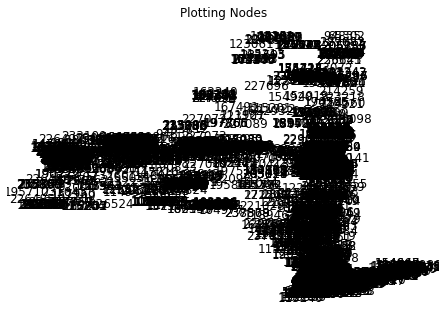

In [16]:

for i in range(1, (df.shape[0])):
        G.add_node(df["ID"][i], pos=(df["Longitude"][i], df["Latitude"][i]))
nx.draw(G, nx.get_node_attributes(G, 'pos'),with_labels=True, node_size=100000, node_color="w")
plt.title("Plotting Nodes")
plt.show()

In [ ]:
fig, ax = plt.subplots()
pos = nx.spring_layout(G)
plt.title("Plotting Nodes")
nx.draw_networkx_nodes(G, pos, ax = ax)

In [ ]:
gdf = gpd.GeoDataFrame(
    tesla_df, geometry=gpd.points_from_xy(tesla_df.Longitude, tesla_df.Latitude)
)

In [ ]:
gdf

In [ ]:
W = libpysal.weights.Queen.from_dataframe(tesla_df)  # generate spatial weights
G = W.to_networkx() # get networkx.Graph

In [ ]:
fig, ax = plt.subplots()
pos = nx.spring_layout(G)
plt.title("Plotting Nodes")
nx.draw_networkx_nodes(G, pos, ax = ax)